# Kernel Methods Tutorial
## CMSC 173 - Machine Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/njpinton/CMSC173/blob/main/05-KernelMethods/notebook/kernel_methods_tutorial.ipynb)

This notebook accompanies the kernel methods slides and provides hands-on implementation and visualization of key concepts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC, SVR
from sklearn.datasets import make_classification, make_regression, make_circles, make_moons
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
np.random.seed(42)

## 1. Introduction & Motivation

Kernel methods solve the fundamental problem of learning non-linear patterns in data by implicitly mapping features to higher-dimensional spaces. This section demonstrates why we need kernel methods through visualization of linear vs non-linear separability.

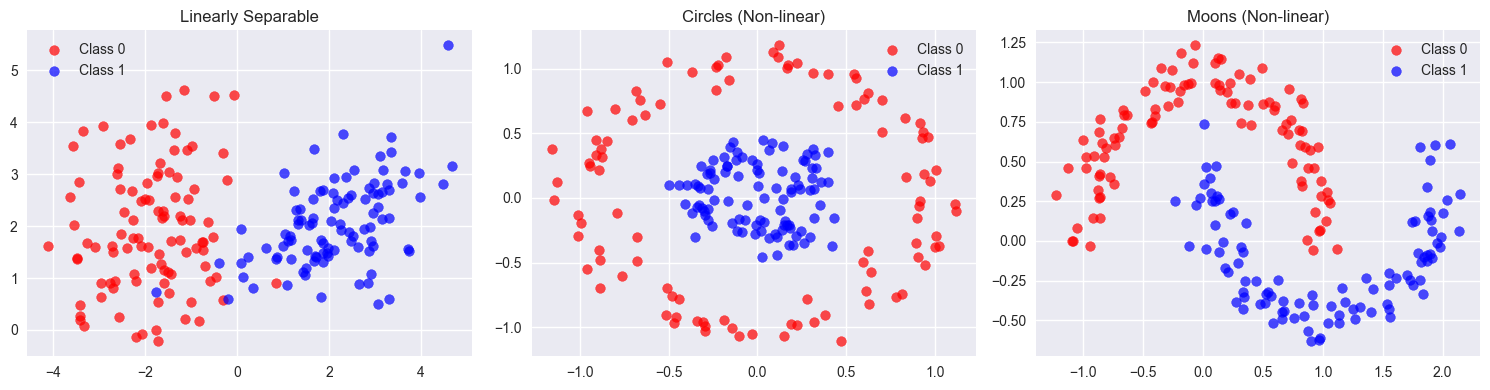

In [2]:
# Create linearly separable data
X_linear, y_linear = make_classification(n_samples=200, n_features=2, n_redundant=0, 
                                        n_informative=2, n_clusters_per_class=1, 
                                        class_sep=2, random_state=42)

# Create non-linearly separable data
X_circles, y_circles = make_circles(n_samples=200, noise=0.1, factor=0.3, random_state=42)
X_moons, y_moons = make_moons(n_samples=200, noise=0.1, random_state=42)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot linearly separable data
axes[0].scatter(X_linear[y_linear==0, 0], X_linear[y_linear==0, 1], c='red', alpha=0.7, label='Class 0')
axes[0].scatter(X_linear[y_linear==1, 0], X_linear[y_linear==1, 1], c='blue', alpha=0.7, label='Class 1')
axes[0].set_title('Linearly Separable')
axes[0].legend()

# Plot circles data
axes[1].scatter(X_circles[y_circles==0, 0], X_circles[y_circles==0, 1], c='red', alpha=0.7, label='Class 0')
axes[1].scatter(X_circles[y_circles==1, 0], X_circles[y_circles==1, 1], c='blue', alpha=0.7, label='Class 1')
axes[1].set_title('Circles (Non-linear)')
axes[1].legend()

# Plot moons data
axes[2].scatter(X_moons[y_moons==0, 0], X_moons[y_moons==0, 1], c='red', alpha=0.7, label='Class 0')
axes[2].scatter(X_moons[y_moons==1, 0], X_moons[y_moons==1, 1], c='blue', alpha=0.7, label='Class 1')
axes[2].set_title('Moons (Non-linear)')
axes[2].legend()

plt.tight_layout()
plt.show()

## 2. Support Vector Machines - Linear Case

Support Vector Machines find the optimal decision boundary by maximizing the margin between classes. This section demonstrates the fundamental SVM concepts using linearly separable data.

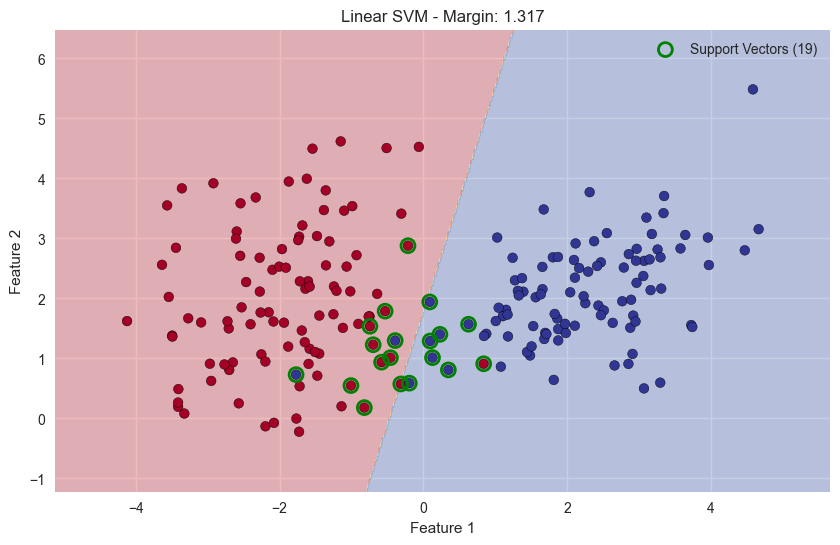

In [3]:
def plot_svm_decision_boundary(X, y, model, title):
    """Plot SVM decision boundary with support vectors highlighted."""
    plt.figure(figsize=(10, 6))

    # Create mesh for decision boundary
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict on mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)

    # Plot data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')

    # Highlight support vectors
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                s=100, facecolors='none', edgecolors='green', linewidths=2,
                label=f'Support Vectors ({len(model.support_vectors_)})')

    # Show margin only for linear kernels
    if hasattr(model, 'kernel') and model.kernel == 'linear':
        margin = 2/np.linalg.norm(model.coef_)
        plt.title(f'{title} - Margin: {margin:.3f}')
    else:
        plt.title(f'{title}')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# Train linear SVM on linearly separable data
svm_linear = SVC(kernel='linear', C=1.0)
svm_linear.fit(X_linear, y_linear)

plot_svm_decision_boundary(X_linear, y_linear, svm_linear, 'Linear SVM')

## 3. Hard vs Soft Margin

Real-world data is rarely perfectly separable. Soft margin SVM allows some misclassifications by introducing slack variables, controlled by the regularization parameter C.

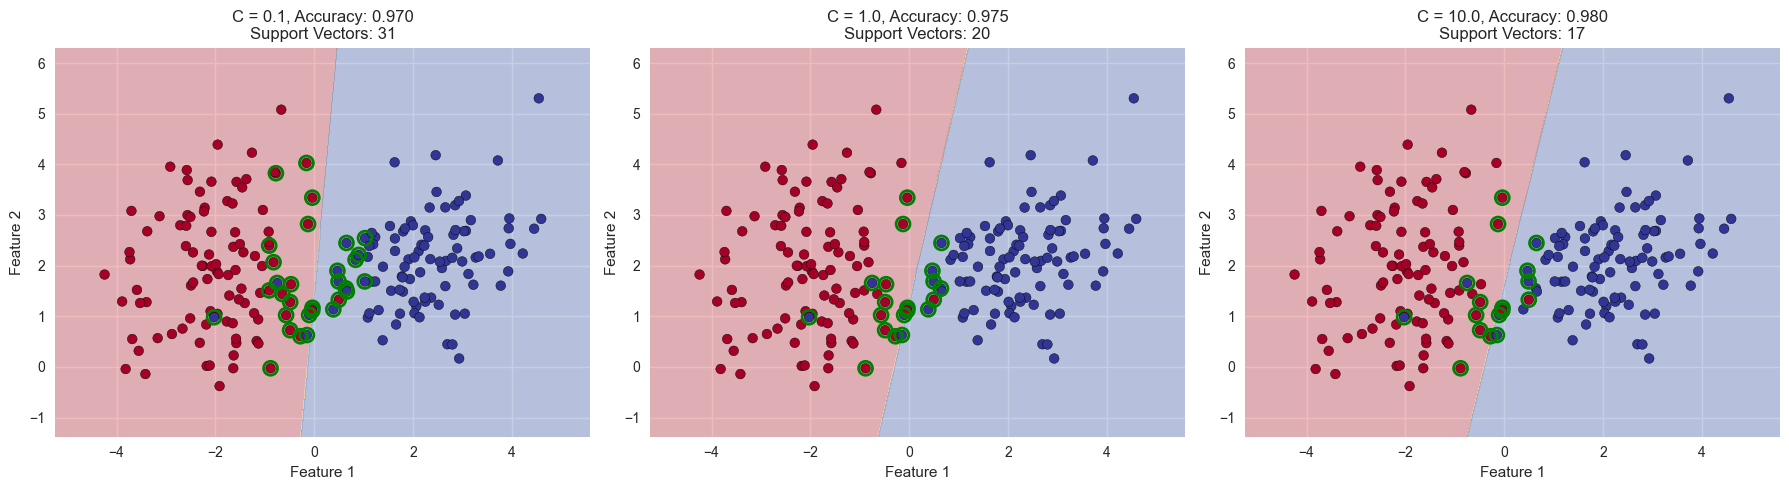

In [4]:
# Add noise to make data not perfectly separable
X_noisy = X_linear + np.random.normal(0, 0.3, X_linear.shape)

# Compare different C values
C_values = [0.1, 1.0, 10.0]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, C in enumerate(C_values):
    svm = SVC(kernel='linear', C=C)
    svm.fit(X_noisy, y_linear)
    
    # Create mesh
    h = 0.02
    x_min, x_max = X_noisy[:, 0].min() - 1, X_noisy[:, 0].max() + 1
    y_min, y_max = X_noisy[:, 1].min() - 1, X_noisy[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axes[i].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    axes[i].scatter(X_noisy[:, 0], X_noisy[:, 1], c=y_linear, cmap=plt.cm.RdYlBu, edgecolors='black')
    axes[i].scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1],
                   s=100, facecolors='none', edgecolors='green', linewidths=2)
    
    accuracy = svm.score(X_noisy, y_linear)
    axes[i].set_title(f'C = {C}, Accuracy: {accuracy:.3f}\nSupport Vectors: {len(svm.support_vectors_)}')
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

## 4. The Kernel Trick

The kernel trick allows SVMs to find non-linear decision boundaries by implicitly mapping data to higher-dimensional spaces. This section demonstrates how different kernels handle non-linear data.

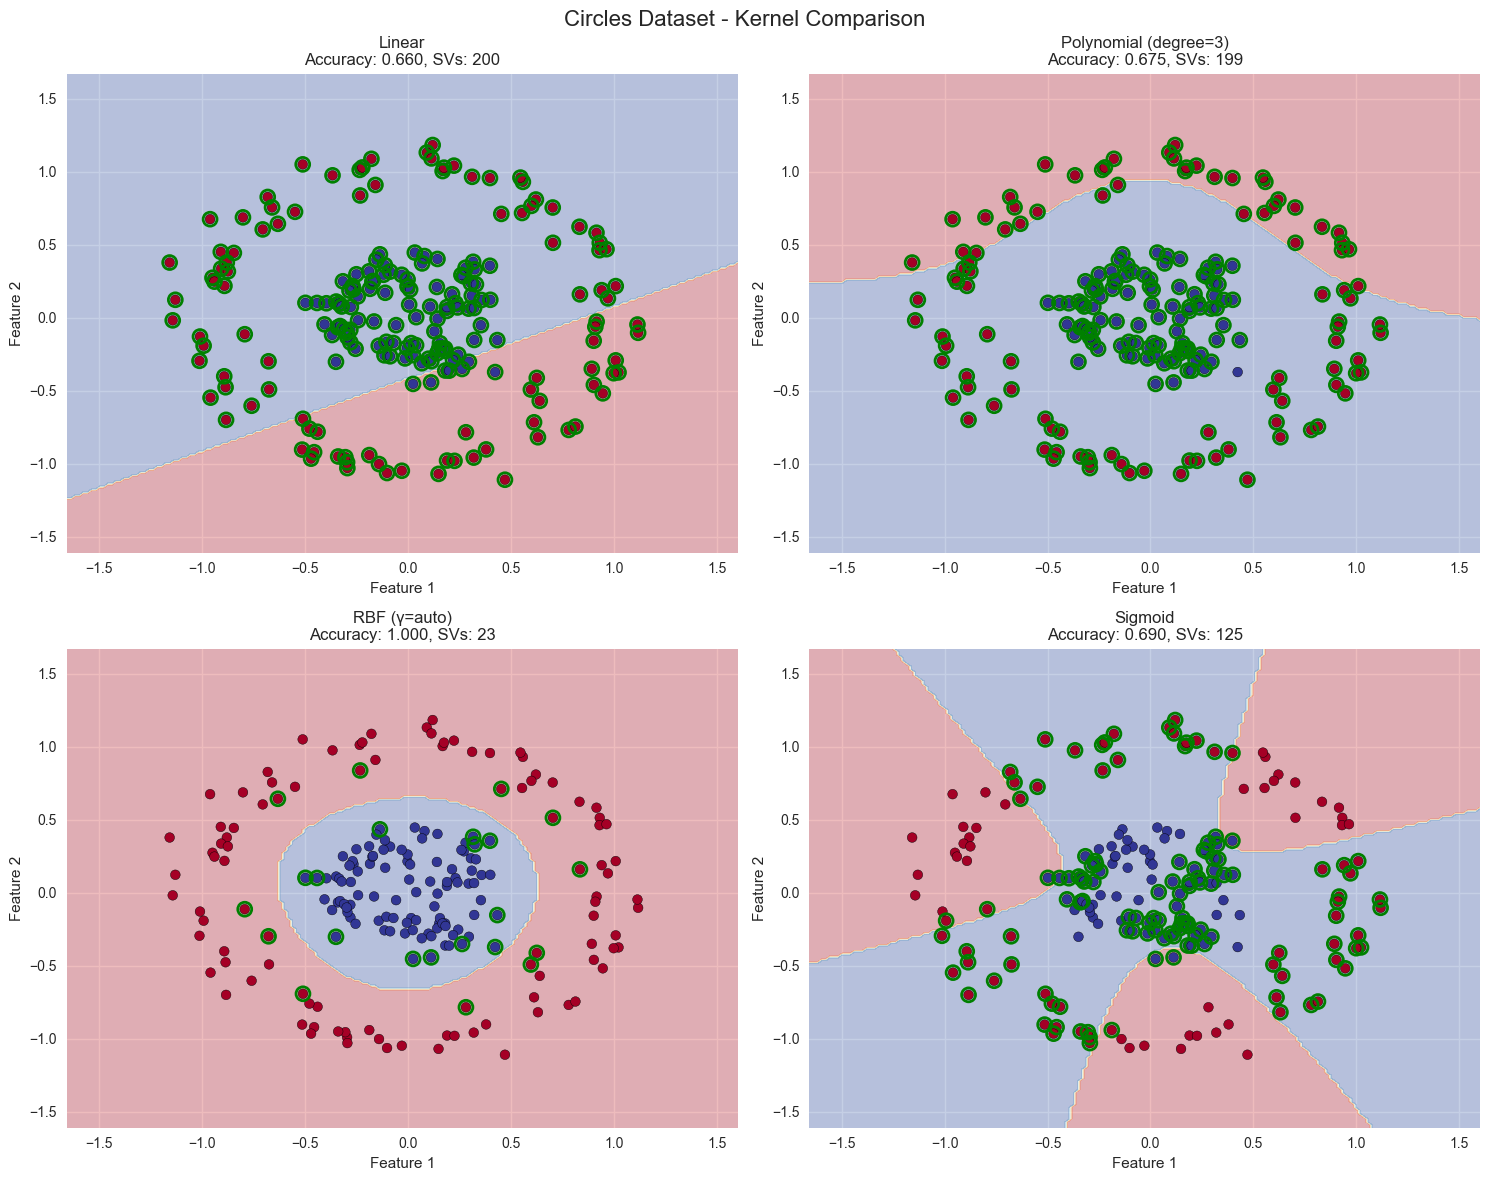

In [5]:
def compare_kernels(X, y, title_prefix):
    """Compare different kernel functions on the same dataset."""
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    kernel_names = ['Linear', 'Polynomial (degree=3)', 'RBF (γ=auto)', 'Sigmoid']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for i, (kernel, name) in enumerate(zip(kernels, kernel_names)):
        if kernel == 'poly':
            svm = SVC(kernel=kernel, degree=3, C=1.0)
        else:
            svm = SVC(kernel=kernel, C=1.0)
        
        svm.fit(X, y)
        
        # Create mesh
        h = 0.02
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        axes[i].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
        axes[i].scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
        axes[i].scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1],
                       s=100, facecolors='none', edgecolors='green', linewidths=2)
        
        accuracy = svm.score(X, y)
        axes[i].set_title(f'{name}\nAccuracy: {accuracy:.3f}, SVs: {len(svm.support_vectors_)}')
        axes[i].set_xlabel('Feature 1')
        axes[i].set_ylabel('Feature 2')
    
    plt.suptitle(f'{title_prefix} - Kernel Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()

# Compare kernels on circles dataset
compare_kernels(X_circles, y_circles, 'Circles Dataset')

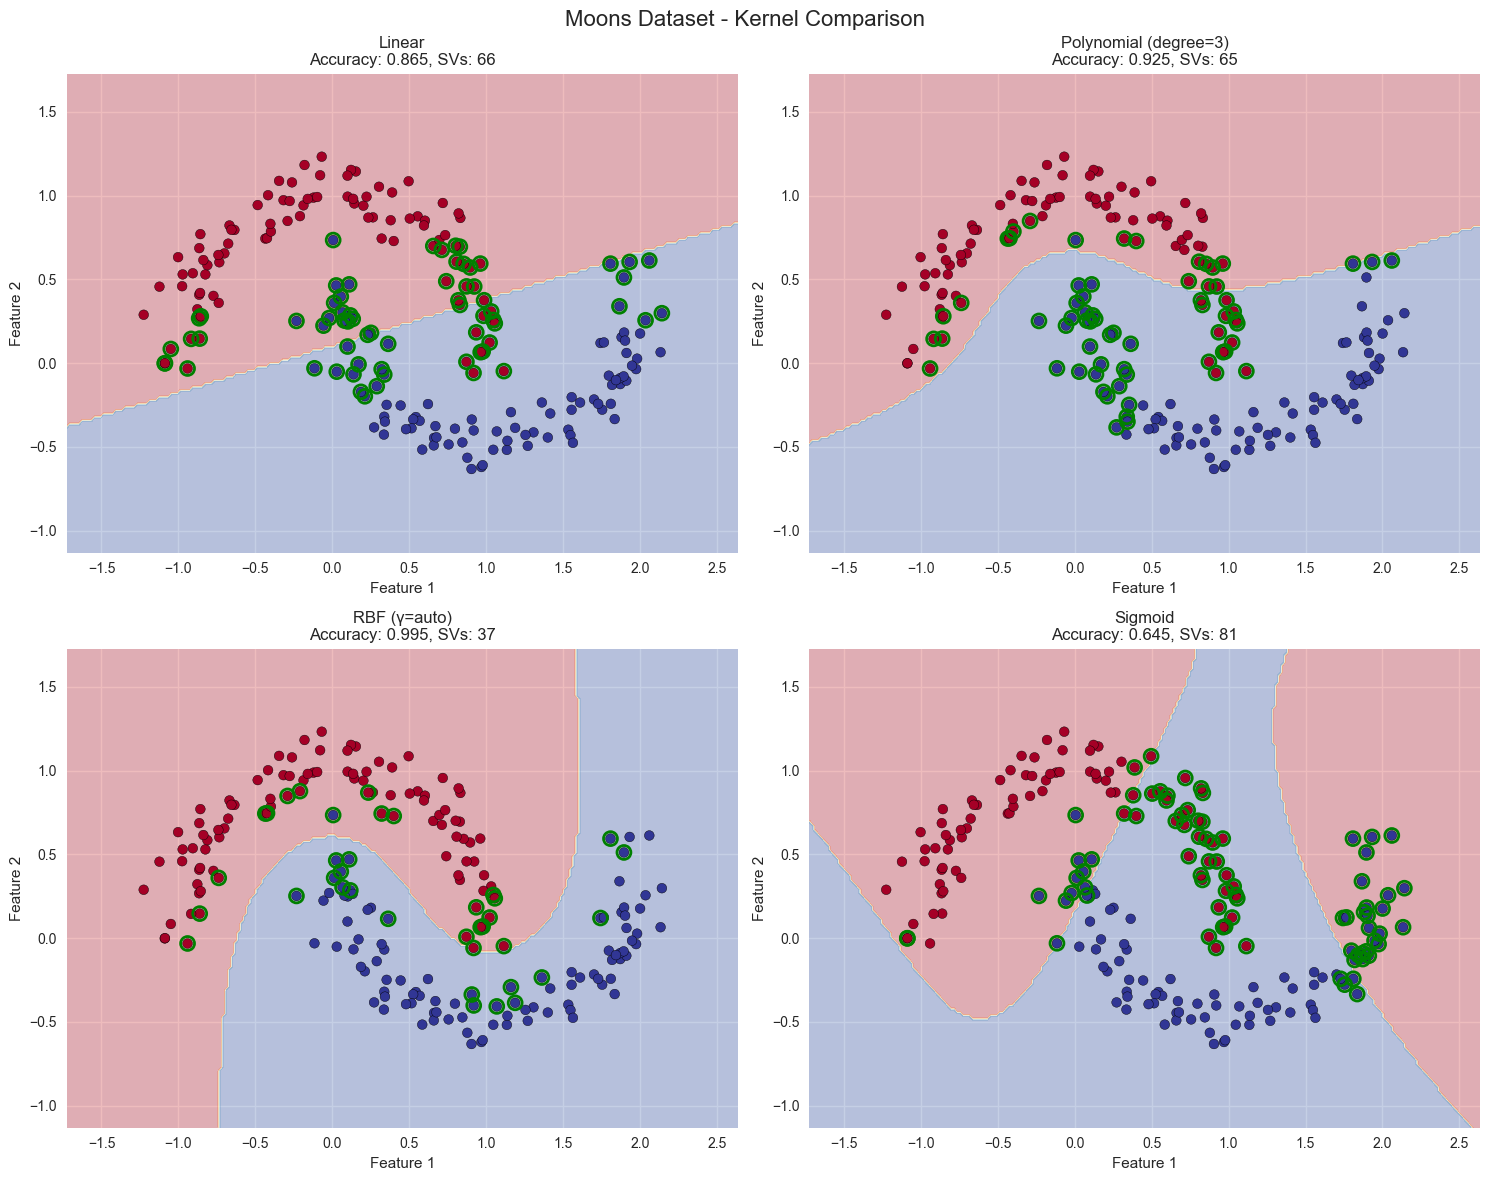

In [6]:
# Compare kernels on moons dataset
compare_kernels(X_moons, y_moons, 'Moons Dataset')

## 5. RBF Kernel Parameter Tuning

The RBF (Radial Basis Function) kernel is the most popular kernel for SVMs. Its performance depends heavily on two parameters: C (regularization) and γ (kernel coefficient). This section explores their effects.

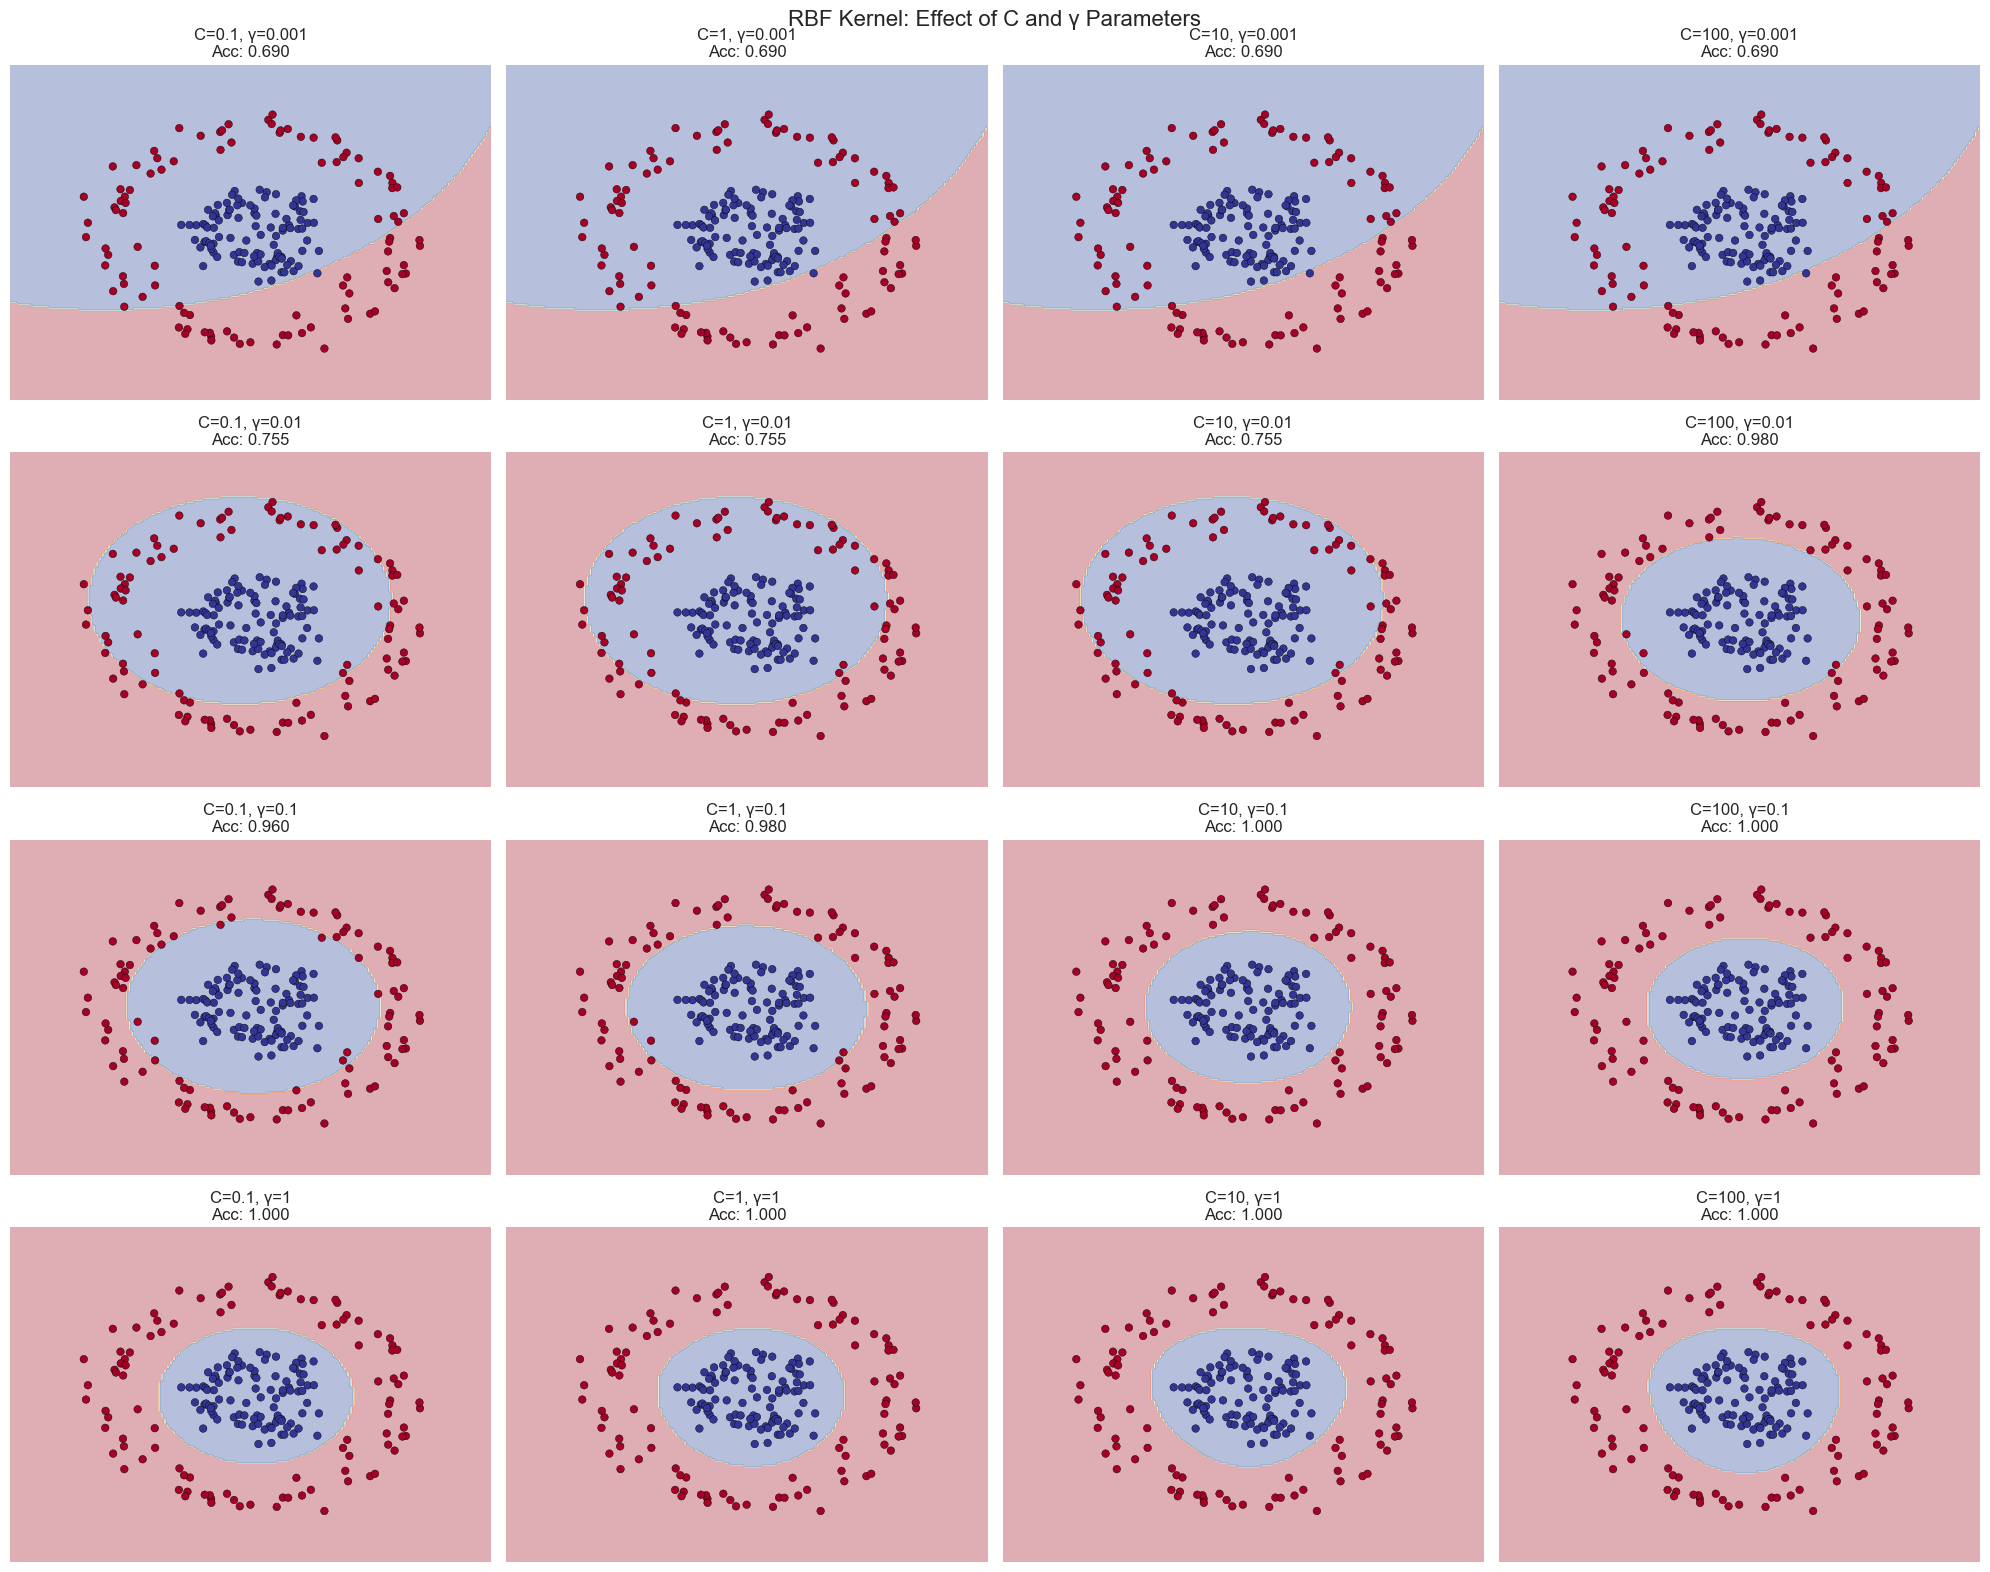

In [7]:
# Parameter grid for RBF kernel
C_range = [0.1, 1, 10, 100]
gamma_range = [0.001, 0.01, 0.1, 1]

fig, axes = plt.subplots(len(gamma_range), len(C_range), figsize=(20, 16))

for i, gamma in enumerate(gamma_range):
    for j, C in enumerate(C_range):
        svm = SVC(kernel='rbf', C=C, gamma=gamma)
        svm.fit(X_circles, y_circles)
        
        # Create mesh
        h = 0.02
        x_min, x_max = X_circles[:, 0].min() - 0.5, X_circles[:, 0].max() + 0.5
        y_min, y_max = X_circles[:, 1].min() - 0.5, X_circles[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        axes[i, j].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
        axes[i, j].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, 
                          cmap=plt.cm.RdYlBu, edgecolors='black', s=30)
        
        accuracy = svm.score(X_circles, y_circles)
        axes[i, j].set_title(f'C={C}, γ={gamma}\nAcc: {accuracy:.3f}')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.suptitle('RBF Kernel: Effect of C and γ Parameters', fontsize=16)
plt.tight_layout()
plt.show()

## 6. Multi-class Classification

SVMs are inherently binary classifiers. For multi-class problems, we use strategies like One-vs-Rest (OvR) and One-vs-One (OvO). This section compares these approaches.

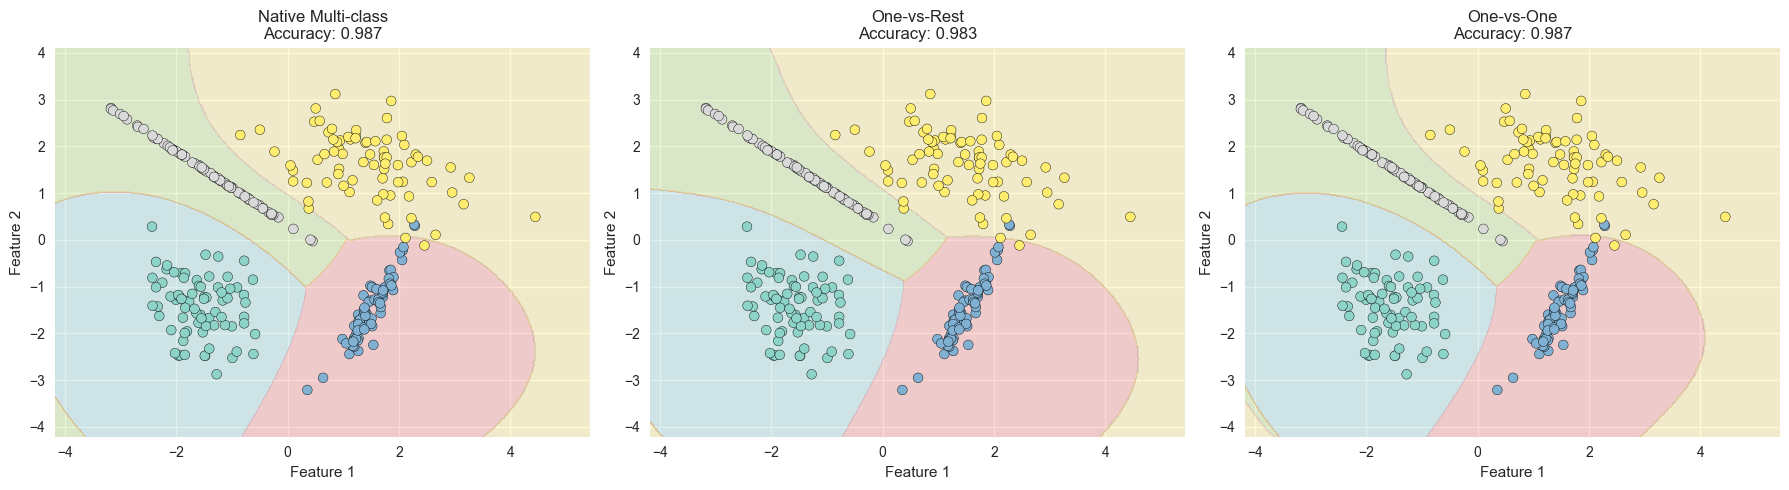

In [8]:
# Create multi-class dataset
X_multi, y_multi = make_classification(n_samples=300, n_features=2, n_classes=4, 
                                      n_redundant=0, n_informative=2, 
                                      n_clusters_per_class=1, class_sep=1.5, 
                                      random_state=42)

# Compare multi-class strategies
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Native multi-class SVM
svm_native = SVC(kernel='rbf', C=1, gamma='scale', decision_function_shape='ovr')
svm_native.fit(X_multi, y_multi)

# One-vs-Rest
svm_ovr = OneVsRestClassifier(SVC(kernel='rbf', C=1, gamma='scale'))
svm_ovr.fit(X_multi, y_multi)

# One-vs-One
svm_ovo = OneVsOneClassifier(SVC(kernel='rbf', C=1, gamma='scale'))
svm_ovo.fit(X_multi, y_multi)

models = [svm_native, svm_ovr, svm_ovo]
titles = ['Native Multi-class', 'One-vs-Rest', 'One-vs-One']

for i, (model, title) in enumerate(zip(models, titles)):
    # Create mesh
    h = 0.02
    x_min, x_max = X_multi[:, 0].min() - 1, X_multi[:, 0].max() + 1
    y_min, y_max = X_multi[:, 1].min() - 1, X_multi[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axes[i].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set3)
    scatter = axes[i].scatter(X_multi[:, 0], X_multi[:, 1], c=y_multi, 
                             cmap=plt.cm.Set3, edgecolors='black')
    
    accuracy = model.score(X_multi, y_multi)
    axes[i].set_title(f'{title}\nAccuracy: {accuracy:.3f}')
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

## 7. Support Vector Regression (SVR)

Support Vector Regression extends SVM concepts to regression problems. It uses ε-insensitive loss function and can handle non-linear relationships using kernels.

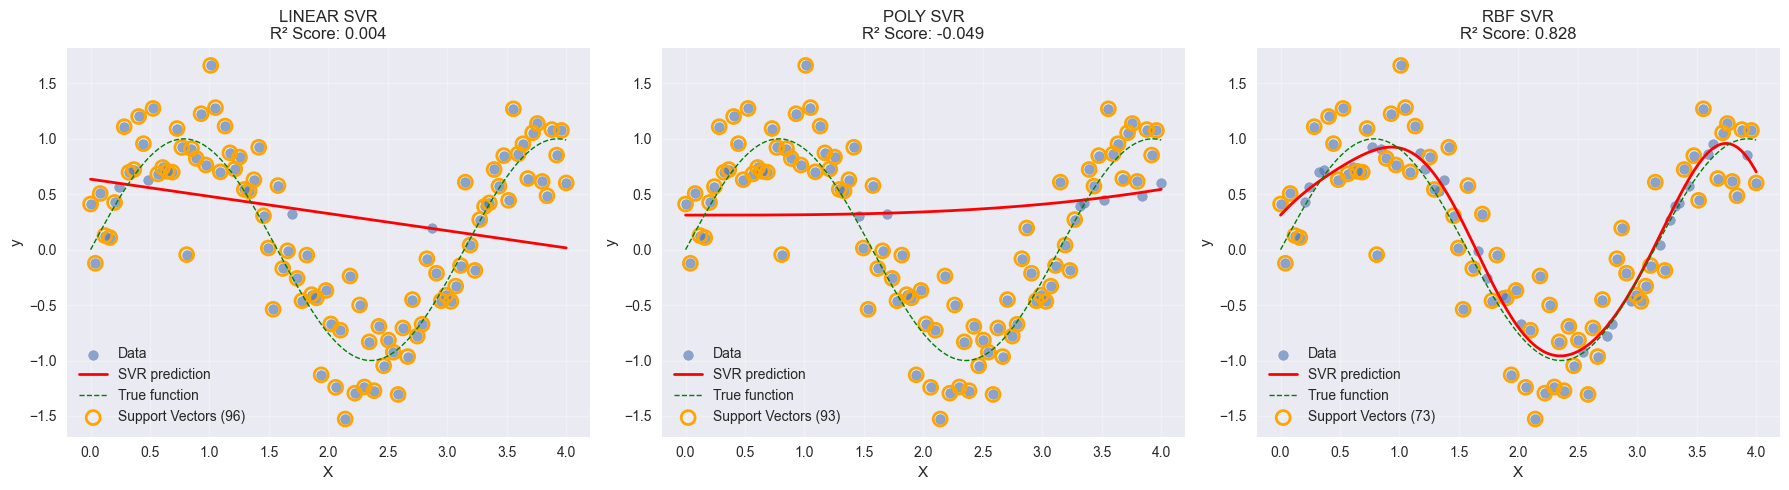

In [9]:
# Generate regression data with noise
def generate_regression_data(n_samples=100, noise=0.3):
    X = np.linspace(0, 4, n_samples).reshape(-1, 1)
    y = np.sin(2 * X).ravel() + np.random.normal(0, noise, X.shape[0])
    return X, y

X_reg, y_reg = generate_regression_data()

# Compare different SVR kernels
kernels = ['linear', 'poly', 'rbf']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Create fine grid for smooth curves
X_plot = np.linspace(0, 4, 300).reshape(-1, 1)

for i, kernel in enumerate(kernels):
    if kernel == 'poly':
        svr = SVR(kernel=kernel, degree=3, C=100, epsilon=0.1)
    else:
        svr = SVR(kernel=kernel, C=100, epsilon=0.1)
    
    svr.fit(X_reg, y_reg)
    y_pred = svr.predict(X_plot)
    
    axes[i].scatter(X_reg, y_reg, alpha=0.6, label='Data')
    axes[i].plot(X_plot, y_pred, color='red', linewidth=2, label='SVR prediction')
    axes[i].plot(X_plot, np.sin(2 * X_plot).ravel(), color='green', 
                linewidth=1, linestyle='--', label='True function')
    
    # Highlight support vectors
    axes[i].scatter(X_reg[svr.support_], y_reg[svr.support_], 
                   s=100, facecolors='none', edgecolors='orange', 
                   linewidths=2, label=f'Support Vectors ({len(svr.support_)})')
    
    score = svr.score(X_reg, y_reg)
    axes[i].set_title(f'{kernel.upper()} SVR\nR² Score: {score:.3f}')
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('y')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Epsilon Parameter in SVR

The ε parameter in SVR defines the margin of tolerance where no penalty is given to errors. Points within this margin are not considered support vectors.

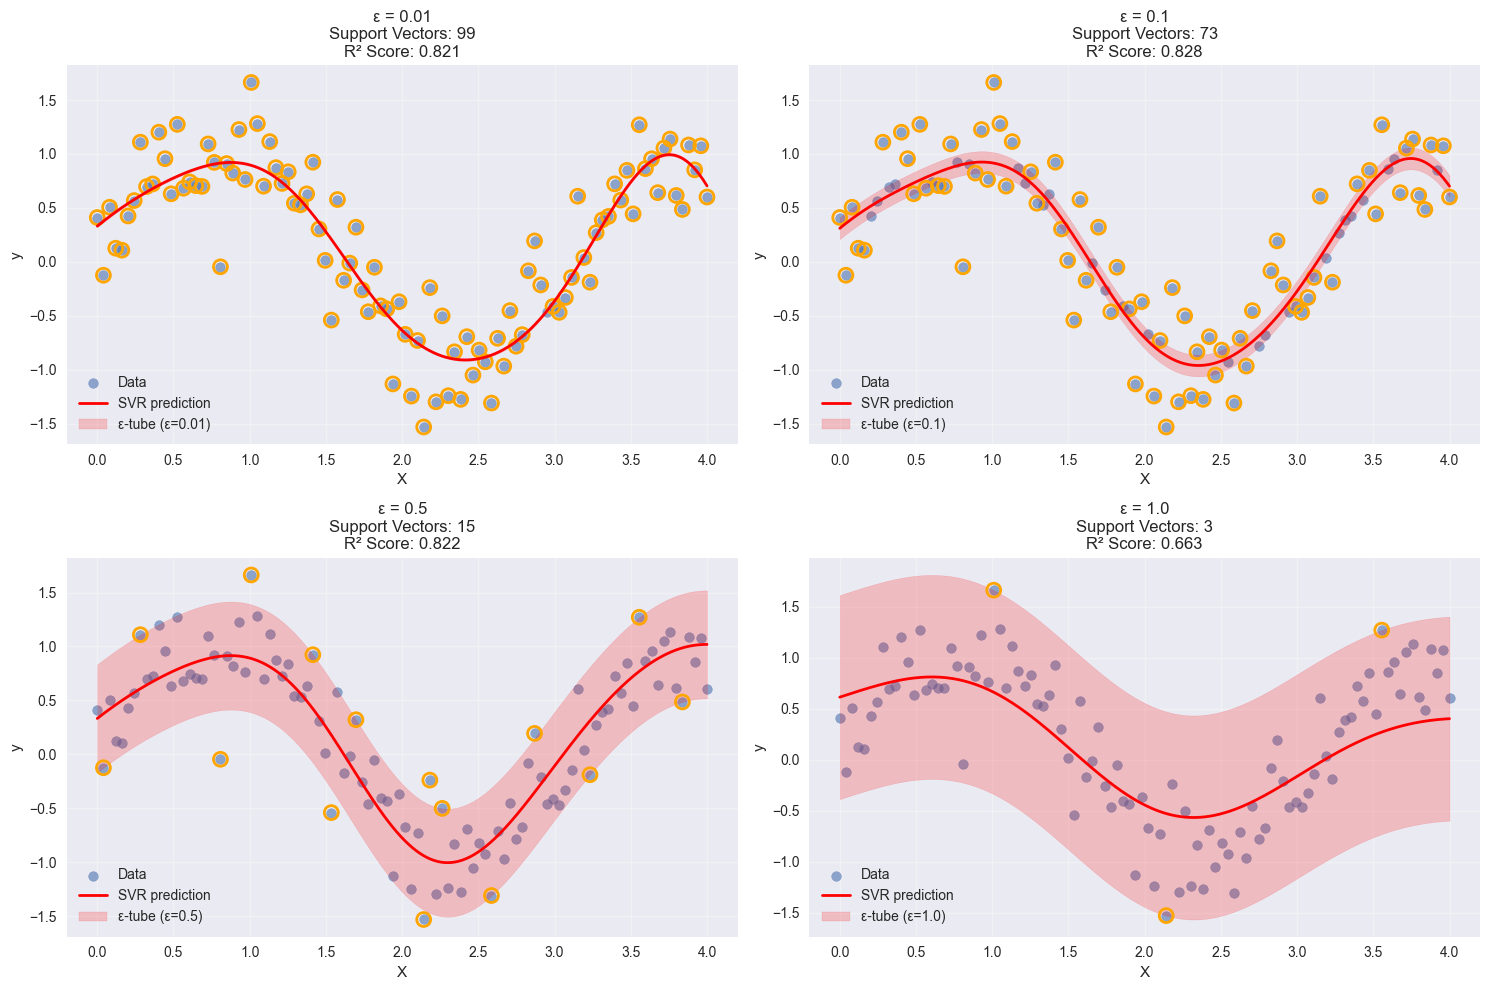

In [10]:
# Effect of epsilon parameter
epsilons = [0.01, 0.1, 0.5, 1.0]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, eps in enumerate(epsilons):
    svr = SVR(kernel='rbf', C=100, epsilon=eps, gamma='scale')
    svr.fit(X_reg, y_reg)
    y_pred = svr.predict(X_plot)
    
    axes[i].scatter(X_reg, y_reg, alpha=0.6, label='Data')
    axes[i].plot(X_plot, y_pred, color='red', linewidth=2, label='SVR prediction')
    
    # Show epsilon tube
    axes[i].fill_between(X_plot.ravel(), y_pred - eps, y_pred + eps, 
                        alpha=0.2, color='red', label=f'ε-tube (ε={eps})')
    
    # Highlight support vectors
    axes[i].scatter(X_reg[svr.support_], y_reg[svr.support_], 
                   s=100, facecolors='none', edgecolors='orange', linewidths=2)
    
    score = svr.score(X_reg, y_reg)
    axes[i].set_title(f'ε = {eps}\nSupport Vectors: {len(svr.support_)}\nR² Score: {score:.3f}')
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('y')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Kernel Ridge Regression Comparison

Kernel Ridge Regression is another kernel method for regression that uses L2 regularization instead of the ε-insensitive loss. This section compares it with SVR.

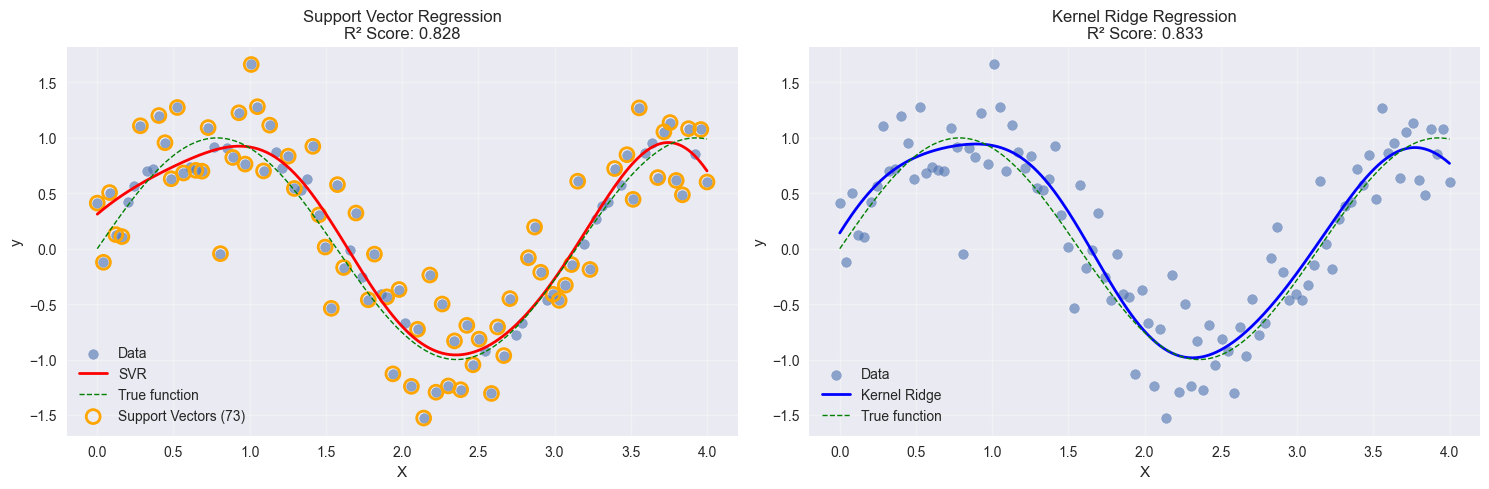

In [11]:
from sklearn.kernel_ridge import KernelRidge

# Compare SVR vs Kernel Ridge Regression
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# SVR
svr = SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale')
svr.fit(X_reg, y_reg)
y_svr = svr.predict(X_plot)

# Kernel Ridge Regression
krr = KernelRidge(kernel='rbf', alpha=0.01, gamma=None)
krr.fit(X_reg, y_reg)
y_krr = krr.predict(X_plot)

# Plot SVR
axes[0].scatter(X_reg, y_reg, alpha=0.6, label='Data')
axes[0].plot(X_plot, y_svr, color='red', linewidth=2, label='SVR')
axes[0].plot(X_plot, np.sin(2 * X_plot).ravel(), color='green', 
            linewidth=1, linestyle='--', label='True function')
axes[0].scatter(X_reg[svr.support_], y_reg[svr.support_], 
               s=100, facecolors='none', edgecolors='orange', linewidths=2,
               label=f'Support Vectors ({len(svr.support_)})')
axes[0].set_title(f'Support Vector Regression\nR² Score: {svr.score(X_reg, y_reg):.3f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Kernel Ridge
axes[1].scatter(X_reg, y_reg, alpha=0.6, label='Data')
axes[1].plot(X_plot, y_krr, color='blue', linewidth=2, label='Kernel Ridge')
axes[1].plot(X_plot, np.sin(2 * X_plot).ravel(), color='green', 
            linewidth=1, linestyle='--', label='True function')
axes[1].set_title(f'Kernel Ridge Regression\nR² Score: {krr.score(X_reg, y_reg):.3f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

for ax in axes:
    ax.set_xlabel('X')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()

## 10. Hyperparameter Optimization

Finding optimal hyperparameters is crucial for SVM performance. This section demonstrates systematic parameter tuning using grid search.

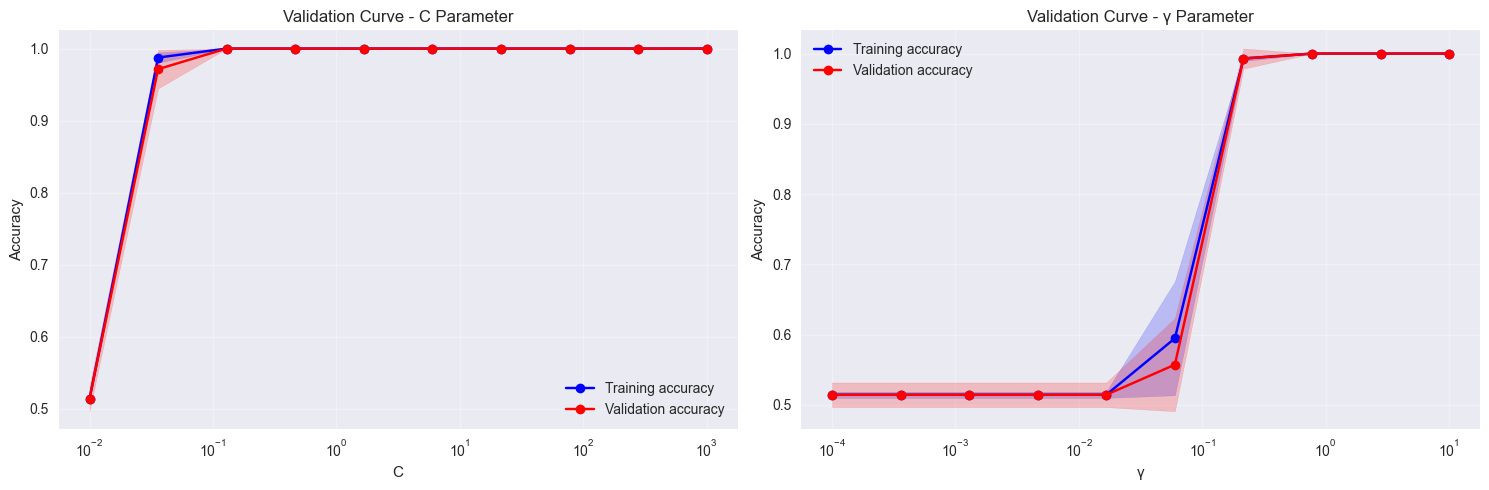

In [12]:
# Grid search for optimal parameters
from sklearn.model_selection import validation_curve

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_circles, y_circles, 
                                                    test_size=0.3, random_state=42)

# Validation curve for C parameter
C_range = np.logspace(-2, 3, 10)
train_scores_C, val_scores_C = validation_curve(
    SVC(kernel='rbf', gamma='scale'), X_train, y_train, 
    param_name='C', param_range=C_range, cv=5, scoring='accuracy'
)

# Validation curve for gamma parameter
gamma_range = np.logspace(-4, 1, 10)
train_scores_gamma, val_scores_gamma = validation_curve(
    SVC(kernel='rbf', C=1.0), X_train, y_train, 
    param_name='gamma', param_range=gamma_range, cv=5, scoring='accuracy'
)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot C parameter validation curve
train_mean_C = np.mean(train_scores_C, axis=1)
train_std_C = np.std(train_scores_C, axis=1)
val_mean_C = np.mean(val_scores_C, axis=1)
val_std_C = np.std(val_scores_C, axis=1)

axes[0].semilogx(C_range, train_mean_C, 'o-', color='blue', label='Training accuracy')
axes[0].fill_between(C_range, train_mean_C - train_std_C, train_mean_C + train_std_C, 
                    alpha=0.2, color='blue')
axes[0].semilogx(C_range, val_mean_C, 'o-', color='red', label='Validation accuracy')
axes[0].fill_between(C_range, val_mean_C - val_std_C, val_mean_C + val_std_C, 
                    alpha=0.2, color='red')
axes[0].set_xlabel('C')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Validation Curve - C Parameter')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot gamma parameter validation curve
train_mean_gamma = np.mean(train_scores_gamma, axis=1)
train_std_gamma = np.std(train_scores_gamma, axis=1)
val_mean_gamma = np.mean(val_scores_gamma, axis=1)
val_std_gamma = np.std(val_scores_gamma, axis=1)

axes[1].semilogx(gamma_range, train_mean_gamma, 'o-', color='blue', label='Training accuracy')
axes[1].fill_between(gamma_range, train_mean_gamma - train_std_gamma, 
                    train_mean_gamma + train_std_gamma, alpha=0.2, color='blue')
axes[1].semilogx(gamma_range, val_mean_gamma, 'o-', color='red', label='Validation accuracy')
axes[1].fill_between(gamma_range, val_mean_gamma - val_std_gamma, 
                    val_mean_gamma + val_std_gamma, alpha=0.2, color='red')
axes[1].set_xlabel('γ')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Curve - γ Parameter')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Best parameters: {'C': 0.1, 'gamma': 1}
Best cross-validation score: 1.000
Test accuracy: 1.000


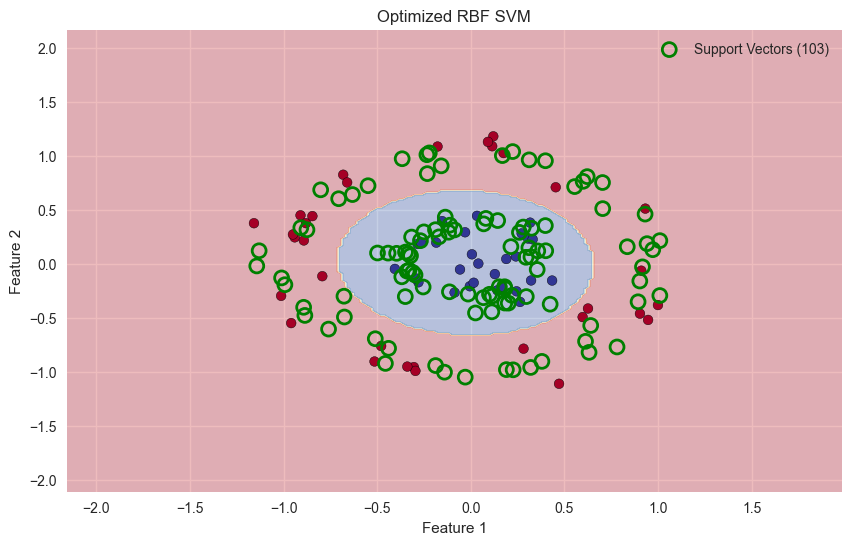

In [13]:
# Grid search for best combination
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Test the best model
best_svm = grid_search.best_estimator_
test_accuracy = best_svm.score(X_test, y_test)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")

# Visualize the best model
plot_svm_decision_boundary(X_test, y_test, best_svm, 'Optimized RBF SVM')

## Summary

This notebook demonstrated key concepts in kernel methods:

1. **Linear vs Non-linear Separability**: Understanding when kernel methods are needed
2. **Support Vector Machines**: Maximum margin classification with support vectors
3. **Soft Margins**: Handling non-separable data with regularization parameter C
4. **Kernel Trick**: Implicit mapping to higher dimensions using different kernels
5. **Parameter Tuning**: Effect of C and γ on model complexity and performance
6. **Multi-class Extensions**: One-vs-Rest and One-vs-One strategies
7. **Support Vector Regression**: Extending SVM concepts to regression problems
8. **Hyperparameter Optimization**: Systematic approach to finding optimal parameters

**Key Takeaways:**
- RBF kernel works well for most non-linear problems
- Parameter tuning is crucial for optimal performance
- SVMs are powerful but require careful preprocessing and parameter selection
- Kernel methods provide elegant solutions to non-linear problems through implicit feature mapping

---

# 🎯 Practice Activities

The following activities will help you apply and deepen your understanding of kernel methods. Complete these exercises to master the concepts covered in this tutorial.

## Activity 1: Custom Kernel Implementation

**Objective**: Implement and test a custom polynomial kernel function.

**Task**: Complete the polynomial kernel function below and compare its performance with scikit-learn's built-in polynomial kernel on the moons dataset.

In [14]:
# Activity 1: Custom Kernel Implementation
def polynomial_kernel(X, Y, degree=3, coef0=1):
    """
    Implement polynomial kernel: K(x, y) = (γ * x^T * y + coef0)^degree
    
    Parameters:
    X: array-like, shape (n_samples, n_features)
    Y: array-like, shape (n_samples, n_features) 
    degree: int, degree of polynomial
    coef0: float, independent term
    
    Returns:
    K: array-like, shape (n_samples, n_samples) - kernel matrix
    """
    # TODO: Implement the polynomial kernel formula
    # Hint: Use np.dot() for matrix multiplication and np.power() for exponentiation
    pass

# Test your implementation
def test_custom_kernel():
    """Test the custom kernel implementation"""
    # Create small test data
    X_test = np.array([[1, 2], [3, 4], [5, 6]])
    
    # TODO: Call your polynomial_kernel function
    custom_K = polynomial_kernel(X_test, X_test, degree=2, coef0=1)
    
    # Compare with sklearn's implementation
    from sklearn.metrics.pairwise import polynomial_kernel as sklearn_poly
    sklearn_K = sklearn_poly(X_test, X_test, degree=2, gamma=1, coef0=1)
    
    print("Custom kernel matrix:")
    print(custom_K)
    print("\nSklearn kernel matrix:") 
    print(sklearn_K)
    print(f"\nMatrices are equal: {np.allclose(custom_K, sklearn_K)}")
    
# Uncomment to test your implementation
# test_custom_kernel()

## Activity 2: Parameter Impact Analysis

**Objective**: Analyze how different parameter values affect SVM decision boundaries.

**Task**: Create a visualization showing how C and γ parameters affect the decision boundary complexity and training accuracy on the circles dataset.

In [15]:
# Activity 2: Parameter Impact Analysis

def analyze_parameter_impact():
    """Analyze the impact of C and gamma parameters on SVM performance"""
    
    # TODO: Create parameter grids
    C_values = [0.01, 0.1, 1, 10, 100]
    gamma_values = [0.001, 0.01, 0.1, 1, 10]
    
    # Create results storage
    results = {'C': [], 'gamma': [], 'train_accuracy': [], 'n_support_vectors': []}
    
    # TODO: Loop through parameter combinations
    for C in C_values:
        for gamma in gamma_values:
            # Train SVM with current parameters
            svm = SVC(kernel='rbf', C=C, gamma=gamma)
            svm.fit(X_circles, y_circles)
            
            # Store results
            results['C'].append(C)
            results['gamma'].append(gamma)
            results['train_accuracy'].append(svm.score(X_circles, y_circles))
            results['n_support_vectors'].append(len(svm.support_vectors_))
    
    # TODO: Create visualization of results
    # Hint: Use plt.scatter() with color mapping for accuracy and size for support vectors
    # Consider using plt.colorbar() to show the color scale
    
    pass

# Uncomment to run the analysis
# analyze_parameter_impact()

## Activity 3: Real-World Dataset Challenge

**Objective**: Apply kernel methods to a real-world classification problem.

**Task**: Load the wine dataset from scikit-learn, apply different kernel methods, and determine which approach works best for this multi-class problem.

In [16]:
# Activity 3: Real-World Dataset Challenge
from sklearn.datasets import load_wine
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

def wine_classification_challenge():
    """Apply kernel methods to wine classification dataset"""
    
    # TODO: Load the wine dataset
    # Hint: Use load_wine() function
    
    # TODO: Split into train/test sets
    # Hint: Use train_test_split with test_size=0.3
    
    # TODO: Standardize the features
    # Hint: Use StandardScaler - this is crucial for SVM!
    
    # TODO: Try different kernels and compare performance
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    results = {}
    
    for kernel in kernels:
        # TODO: Train SVM with current kernel
        # TODO: Make predictions on test set
        # TODO: Calculate accuracy and store results
        pass
    
    # TODO: Find the best performing kernel
    # TODO: Print results and classification report for best kernel
    
    print("Wine Classification Results:")
    print("============================")
    # TODO: Display your results here
    
# Uncomment to run the challenge
# wine_classification_challenge()

## Activity 4: SVR Parameter Optimization

**Objective**: Optimize Support Vector Regression parameters for a noisy regression problem.

**Task**: Create a noisy sine wave dataset and find optimal ε, C, and γ parameters using cross-validation.

In [17]:
# Activity 4: SVR Parameter Optimization

def svr_parameter_optimization():
    """Optimize SVR parameters for noisy sine wave regression"""
    
    # TODO: Create a noisy sine wave dataset
    # Hint: Use np.linspace and np.sin, add noise with np.random.normal
    np.random.seed(42)
    X = np.linspace(0, 4*np.pi, 200).reshape(-1, 1)
    y = np.sin(X).ravel() + np.random.normal(0, 0.3, X.shape[0])
    
    # TODO: Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # TODO: Define parameter grid for GridSearchCV
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.2, 0.5],
        'gamma': ['scale', 0.001, 0.01, 0.1, 1.0]
    }
    
    # TODO: Use GridSearchCV to find best parameters
    # Hint: Use SVR with kernel='rbf' and cv=5
    
    # TODO: Train the best model and make predictions
    
    # TODO: Visualize the results
    # Show: original data, true function, predictions, and support vectors
    
    print("SVR Parameter Optimization Results:")
    print("====================================")
    # TODO: Print best parameters and test score

# Uncomment to run the optimization
# svr_parameter_optimization()

## Activity 5: Kernel Methods Comparison

**Objective**: Compare different kernel methods on the same dataset and analyze their strengths and weaknesses.

**Task**: Apply SVM, Kernel Ridge Regression, and Gaussian Process Regression to a regression problem and compare their performance, computational efficiency, and uncertainty quantification.

In [18]:
# Activity 5: Kernel Methods Comparison
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error, r2_score

def compare_kernel_methods():
    """Compare SVR, Kernel Ridge, and Gaussian Process Regression"""
    
    # Generate complex regression dataset
    np.random.seed(42)
    X = np.linspace(0, 10, 100).reshape(-1, 1)
    y = (0.5 * X.ravel() * np.sin(3 * X.ravel()) + 
         0.3 * np.cos(5 * X.ravel()) + 
         np.random.normal(0, 0.3, X.shape[0]))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_plot = np.linspace(0, 10, 200).reshape(-1, 1)
    
    methods = {}
    
    # TODO: Initialize and train different kernel methods
    
    # 1. Support Vector Regression
    # TODO: Create SVR with RBF kernel, tune parameters if needed
    
    # 2. Kernel Ridge Regression  
    # TODO: Create KernelRidge with RBF kernel
    
    # 3. Gaussian Process Regression
    # TODO: Create GaussianProcessRegressor with RBF kernel
    # Hint: Use kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
    
    # TODO: Train all methods and measure training time
    
    # TODO: Make predictions and measure prediction time
    
    # TODO: Calculate performance metrics (MSE, R²)
    
    # TODO: Create comparison visualization
    # Show: data points, predictions from all methods, uncertainty bands (for GP)
    
    # TODO: Print comparison table
    print("Kernel Methods Comparison:")
    print("==========================")
    print(f"{'Method':<20} {'Train Time':<12} {'Test R²':<10} {'Test MSE':<10}")
    print("-" * 55)
    
# Uncomment to run the comparison
# compare_kernel_methods()

## 🏆 Challenge: Create Your Own Kernel

**Advanced Challenge**: Design and implement a custom kernel function that combines multiple kernel types.

**Task**: Create a "mixed kernel" that combines linear, polynomial, and RBF components, then test its performance on a challenging dataset.

In [19]:
# 🏆 Challenge: Create Your Own Kernel

def mixed_kernel(X, Y, alpha=0.3, beta=0.4, gamma=0.3):
    """
    Custom mixed kernel combining linear, polynomial, and RBF components
    K_mixed(x,y) = α*K_linear(x,y) + β*K_poly(x,y) + γ*K_rbf(x,y)
    
    Parameters:
    X, Y: input matrices
    alpha, beta, gamma: weighting parameters (should sum to 1)
    """
    # TODO: Implement the mixed kernel
    # Hint: Use sklearn.metrics.pairwise for individual kernel computations
    pass

def test_mixed_kernel():
    """Test the mixed kernel on a challenging dataset"""
    
    # Create a challenging dataset with multiple patterns
    np.random.seed(42)
    
    # TODO: Create a complex 2D dataset with:
    # - Linear separable region
    # - Polynomial separable region  
    # - Non-linear circular patterns
    
    # TODO: Compare performance of:
    # - Individual kernels (linear, poly, rbf)
    # - Your mixed kernel
    # - Standard kernel combinations
    
    # TODO: Visualize decision boundaries for each approach
    
    # TODO: Report accuracy and training time comparisons
    
    print("Mixed Kernel Challenge Results:")
    print("===============================")
    
# Uncomment to test your mixed kernel
# test_mixed_kernel()

---

## 📚 Additional Resources

**For Further Learning:**
- [scikit-learn SVM User Guide](https://scikit-learn.org/stable/modules/svm.html)
- [Kernel Methods in Machine Learning](https://www.kernel-methods.net/)
- [Understanding the Kernel Trick](https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f)
- [Support Vector Machines Explained](https://www.youtube.com/watch?v=efR1C6CvhmE)

**Key Papers:**
- Cortes, C., & Vapnik, V. (1995). Support-vector networks. Machine Learning, 20(3), 273-297.
- Schölkopf, B., & Smola, A. J. (2002). Learning with kernels: support vector machines, regularization, optimization, and beyond.

**Practice Datasets:**
- Wine classification (`sklearn.datasets.load_wine`)
- Breast cancer (`sklearn.datasets.load_breast_cancer`) 
- Digits recognition (`sklearn.datasets.load_digits`)
- Boston housing (`sklearn.datasets.load_boston`) - deprecated but good for regression practice

---

🎉 **Congratulations!** You've completed the kernel methods tutorial. These activities will help you master the practical application of kernel methods in machine learning projects.